![image.png](https://i.imgur.com/a3uAqnb.png)

# **Day 4 Lab 2: Unsupervised Learning**


---

In this lab, you'll learn how to:

1. **Reduce dimensionality** of MNIST images from 784D to 2D using PCA and t-SNE

2. **Cluster images** using K-Means

3. **Build Autoencoders** and generate new images 🙂‍↕️

> **Recap from the slides:** In unsupervised learning, we work with data **without labels**. The goal is to discover hidden structure, patterns, or groupings in the data.


---

# **Import Libraries**

In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Compose, Normalize

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# **Load the MNIST Dataset**

We'll load MNIST and take a subset for faster processing.

In [2]:
# Load MNIST dataset
train_dataset = MNIST(
  root='./data',
  train=True,
  transform=ToTensor(),
  download=True
)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.08MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 131kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.28MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.4MB/s]


In [3]:
# Take a subset for faster visualization (5000 samples)
N_SAMPLES = 5000
indices = np.random.choice(len(train_dataset), N_SAMPLES, replace=False)

# Extract images and labels
images = []
labels = []

for idx in indices:
  img, label = train_dataset[idx]
  img = img.numpy().flatten() # Flatten makes each 28x28 image into 784D
  images.append(img)
  labels.append(label)

X = np.array(images)  # Shape: (5000, 784)
y = np.array(labels)  # Ground truth labels (for visualization)

print(f"Data shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Unique labels: {np.unique(y)}")

Data shape: (5000, 784)
Labels shape: (5000,)
Unique labels: [0 1 2 3 4 5 6 7 8 9]


---

# **Part 1: Dimensionality Reduction**

## **Why Reduce Dimensions?**

One of the **limitations of K-Means** (and many other algorithms) is that they struggle with **high-dimensional data**. This is known as the **curse of dimensionality**:

- All points tend to be equally far from each other
- Visualization becomes impossible (we can only see 2D or 3D!)

Since MNIST images are **28 × 28 = 784 dimensions**, We'll reduce them to just **2D** so we can see the clustering.



---

## **PCA (Principal Component Analysis)**

**PCA** is a linear technique that finds the directions (principal components) that capture the most variance in the data.

#### 📌 **How PCA Works:**
1. Center the data (subtract the mean)
2. Compute the covariance matrix
3. Find eigenvectors (directions) and eigenvalues (variance)
4. Project data onto the top-k eigenvectors

#### 📌 **Rule of Thumb for Choosing Components:**

> Choose the **minimum number of components** that preserves **80-95%** of the total variance.

You can check this using `pca.explained_variance_ratio_`.

In [4]:
# We use n_components = total features (784) to analyze the importance of every component.
# In reality, if we wanted to actually compress the data to a smaller size, we would pick a smaller number (e.g., 50).
pca_full = PCA(n_components=28*28)
pca_full.fit(X)

# Calculate cumulative variance
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

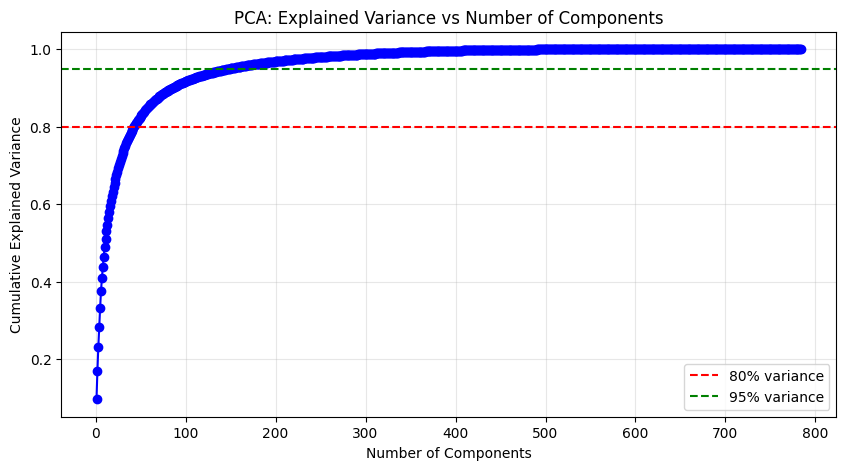

In [5]:
# Plot
plt.figure(figsize=(10, 5))
plt.plot(range(1, 785), cumulative_variance, 'bo-')
plt.axhline(y=0.80, color='r', linestyle='--', label='80% variance')
plt.axhline(y=0.95, color='g', linestyle='--', label='95% variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Explained Variance vs Number of Components')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [6]:
# Create 5 targets from 0.80 (80%) to 0.95 (95%)
targets = np.linspace(0.80, 0.95, 5)

for target in targets:
  # Find the first index where variance is >= target
  # np.argmax returns the index of the first True value
  n_components = np.argmax(cumulative_variance >= target) + 1

  print(f"To keep {target:.2%} variance, you need {n_components} components.")

To keep 80.00% variance, you need 43 components.
To keep 83.75% variance, you need 54 components.
To keep 87.50% variance, you need 70 components.
To keep 91.25% variance, you need 96 components.
To keep 95.00% variance, you need 149 components.


> **Insight:** We can compress 784 dimensions to just ~90 components and still retain most of the information!
---
For visualization though, we'll use just 2 components.

In [7]:
# Apply PCA to reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

print(f"Original shape: {X.shape}")
print(f"After PCA: {X_pca.shape}")
print(f"Variance explained by 2 components: {pca.explained_variance_ratio_.sum():.2%}")

Original shape: (5000, 784)
After PCA: (5000, 2)
Variance explained by 2 components: 16.95%


---

## **t-SNE (t-Distributed Stochastic Neighbor Embedding)**

**t-SNE** is a **non-linear** technique that's excellent for visualization. Unlike PCA, it tries to preserve **local neighborhoods** - points that are close in the higher dimension stay close together.

#### 📌 **Key Differences from PCA:**

| PCA | t-SNE |
|-----|-------|
| Linear | Non-linear |
| Fast | Slower |
| Preserves global structure | Preserves local structure |
| Deterministic | Stochastic (different runs = different results) |
| Used for Compression | Used for Visualization |


> **Note:** t-SNE can be slow on large datasets. That's why we're using a subset!

In [8]:
# Apply t-SNE
print("Running t-SNE... (this may take a minute)")

tsne = TSNE(
  n_components=2,
  random_state=42,
)
X_tsne = tsne.fit_transform(X)

print(f"After t-SNE: {X_tsne.shape}")

Running t-SNE... (this may take a minute)
After t-SNE: (5000, 2)


---

### **PCA vs t-SNE Comparison**

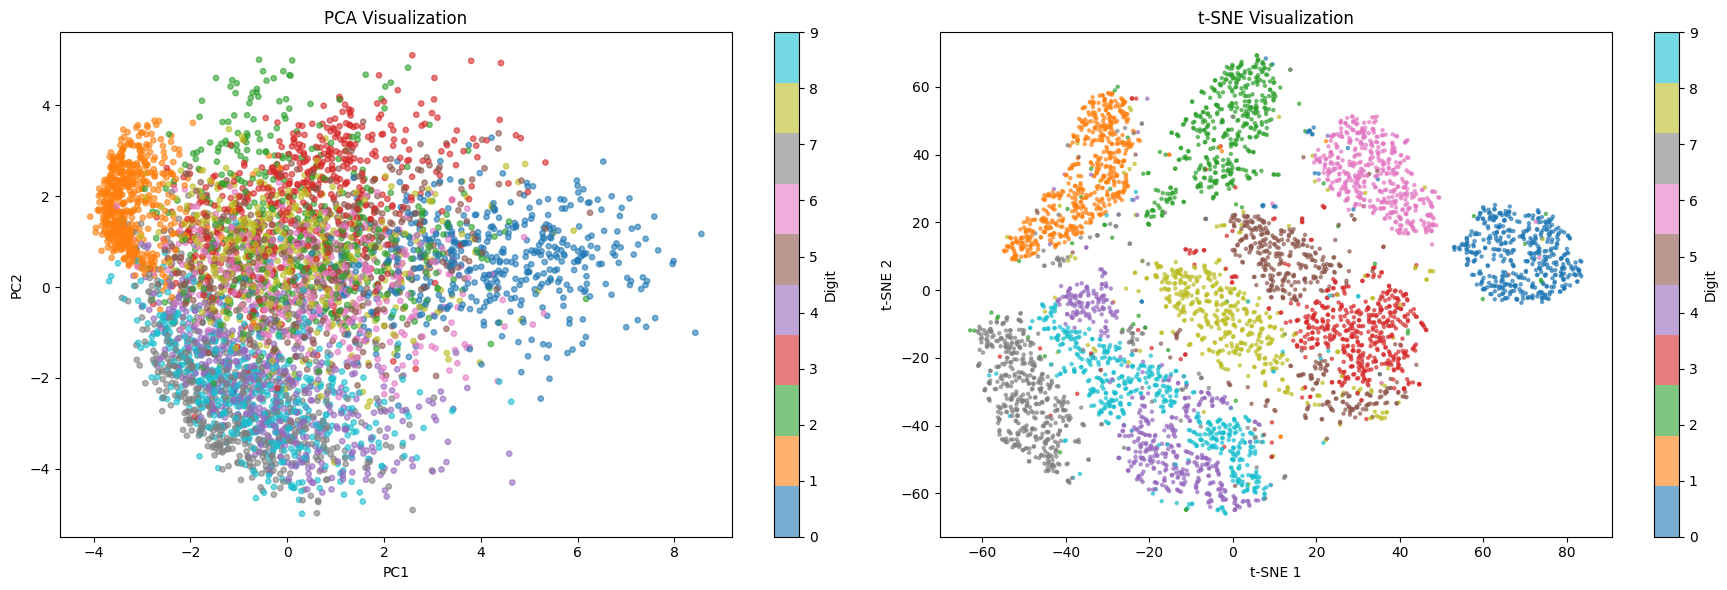

In [9]:
# Side by side comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# PCA
scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='tab10', alpha=0.6, s=15)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_title('PCA Visualization')
plt.colorbar(scatter1, ax=ax1, label='Digit')

# t-SNE
scatter2 = ax2.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='tab10', alpha=0.6, s=5)
ax2.set_xlabel('t-SNE 1')
ax2.set_ylabel('t-SNE 2')
ax2.set_title('t-SNE Visualization')
plt.colorbar(scatter2, ax=ax2, label='Digit')

plt.tight_layout()
plt.show()

> **Observation:** t-SNE is the best for visualizing high dimensional data. It creates more separated clusters because it focuses on preserving local structure.

---

# **Part 2: K-Means Clustering**



Now let's try to discover the digit groups **without using the labels**!

#### 📌 **How K-Means Works:**
1. Initialize k random centroids
2. Assign each point to the nearest centroid
3. Update centroids as the mean of assigned points
4. Repeat steps 2-3 until convergence

#### 📌 **Choosing K (Number of Clusters):**

In real unsupervised learning, **we don't know the true number of clusters**. We can use the **Elbow Method**:

- Compute **Within-Cluster Sum of Squares (WCSS)** for different values of k
- Plot WCSS vs k
- Look for the "elbow" - the point where adding more clusters doesn't help much

> Since we know MNIST has 10 digits, we'll use **k=10** for this lab.

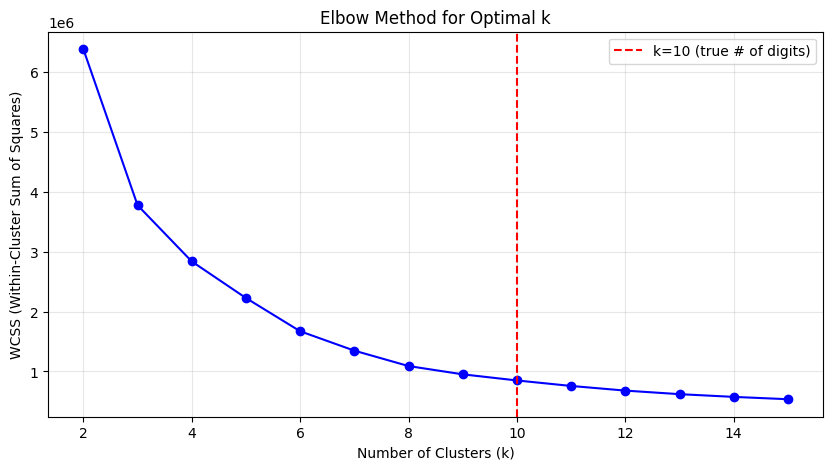

In [10]:
# Let's first demonstrate the Elbow Method
wcss = []  # Within-Cluster Sum of Squares
k_range = range(2, 16)

for k in k_range:
  kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
  kmeans.fit(X_tsne)  # Using t-SNE reduced data
  wcss.append(kmeans.inertia_)

# Plot the Elbow
plt.figure(figsize=(10, 5))
plt.plot(k_range, wcss, 'bo-')
plt.axvline(x=10, color='r', linestyle='--', label='k=10 (true # of digits)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal k')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

> **Insight:** The elbow isn't always obvious. In practice, domain knowledge (like knowing there are 10 digits) helps! When you don't know k, look for where the curve starts to flatten.

In [11]:
K = 10  # Apply K-Means with k=10
n_init = 10 # Repeat the clustering process 10 times

kmeans = KMeans(n_clusters=K, random_state=42, n_init=n_init)

pca_clusters = kmeans.fit_predict(X_pca)  # Using PCA reduced data
tsne_clusters = kmeans.fit_predict(X_tsne)  # Using t-SNE reduced data

print(f"clusters: {np.unique(pca_clusters)}")

clusters: [0 1 2 3 4 5 6 7 8 9]


## **Visualizing Cluster Assignments vs Ground Truth**

Let's compare what K-Means found vs the actual digit labels.

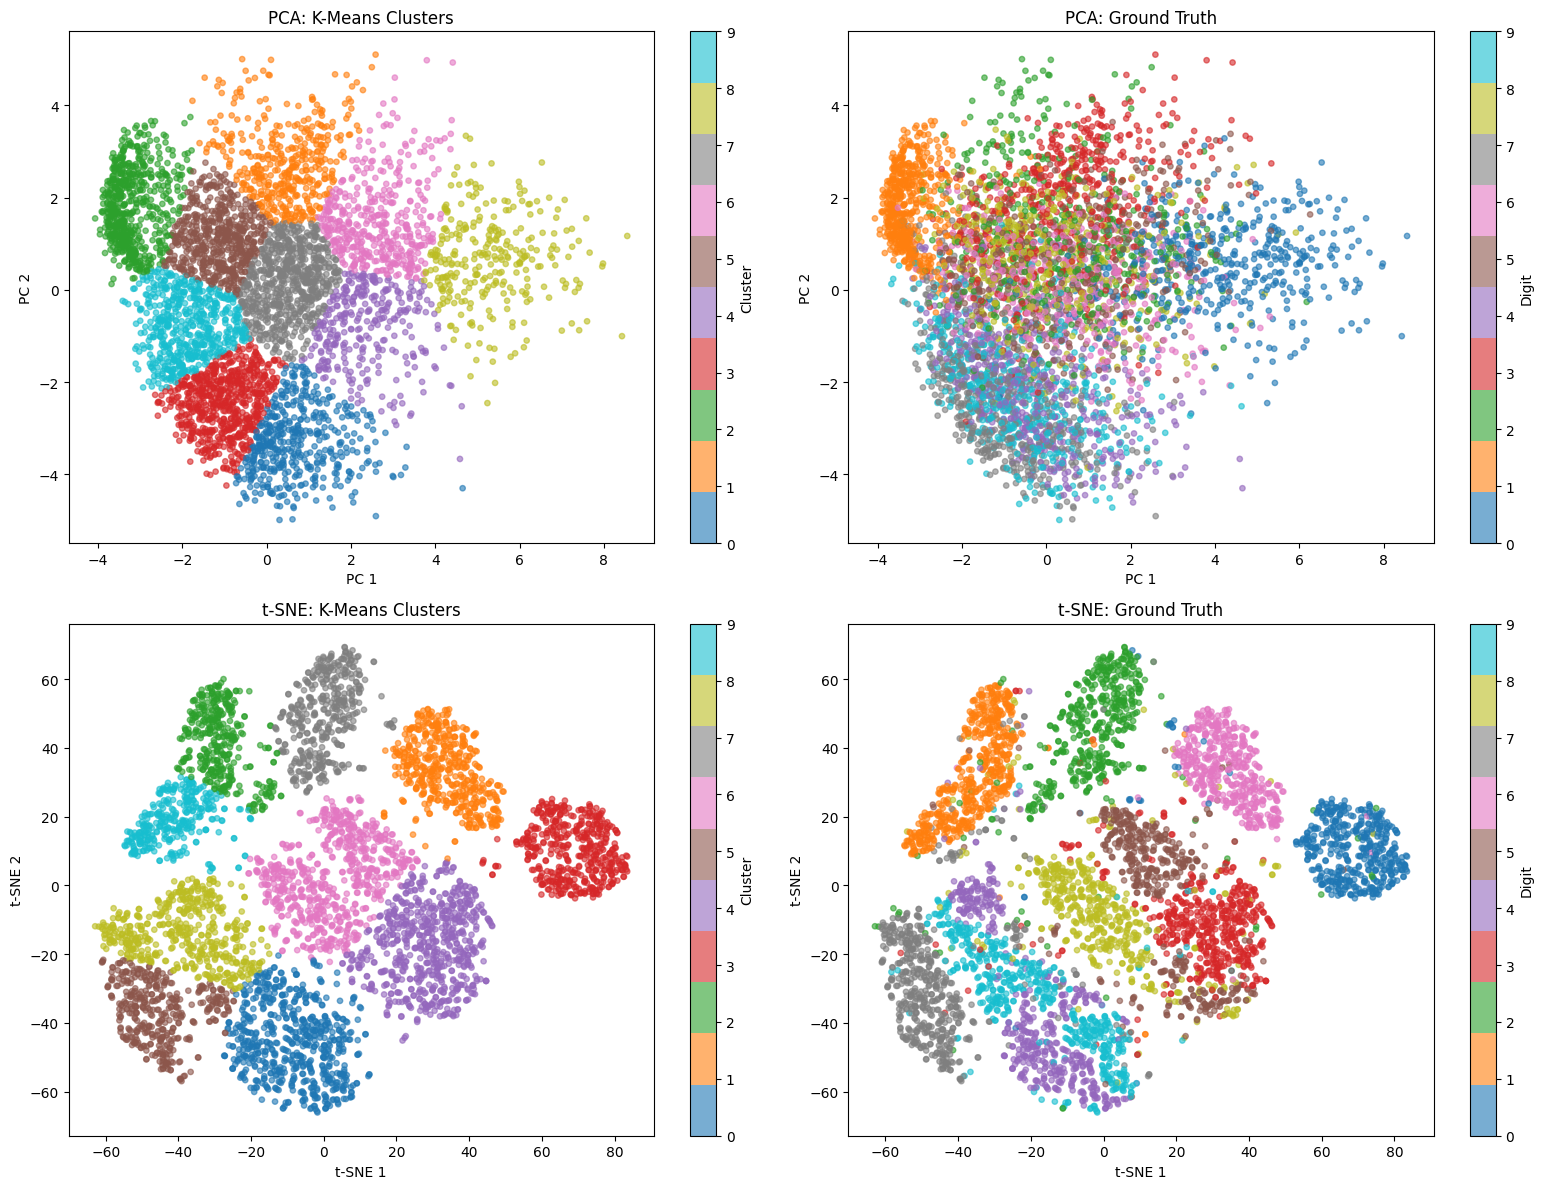

In [12]:
import matplotlib.pyplot as plt

# Create 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# --- Row 1: PCA ---

# Plot 1: PCA - K-Means Clusters
scatter1 = axes[0, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=pca_clusters, cmap='tab10', alpha=0.6, s=15)
axes[0, 0].set_title('PCA: K-Means Clusters')
axes[0, 0].set_xlabel('PC 1')
axes[0, 0].set_ylabel('PC 2')
plt.colorbar(scatter1, ax=axes[0, 0], label='Cluster')

# Plot 2: PCA - Ground Truth
scatter2 = axes[0, 1].scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='tab10', alpha=0.6, s=15)
axes[0, 1].set_title('PCA: Ground Truth')
axes[0, 1].set_xlabel('PC 1')
axes[0, 1].set_ylabel('PC 2')
plt.colorbar(scatter2, ax=axes[0, 1], label='Digit')

# --- Row 2: t-SNE ---

# Plot 3: t-SNE - K-Means Clusters
scatter3 = axes[1, 0].scatter(X_tsne[:, 0], X_tsne[:, 1], c=tsne_clusters, cmap='tab10', alpha=0.6, s=15)
axes[1, 0].set_title('t-SNE: K-Means Clusters')
axes[1, 0].set_xlabel('t-SNE 1')
axes[1, 0].set_ylabel('t-SNE 2')
plt.colorbar(scatter3, ax=axes[1, 0], label='Cluster')

# Plot 4: t-SNE - Ground Truth
scatter4 = axes[1, 1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='tab10', alpha=0.6, s=15)
axes[1, 1].set_title('t-SNE: Ground Truth')
axes[1, 1].set_xlabel('t-SNE 1')
axes[1, 1].set_ylabel('t-SNE 2')
plt.colorbar(scatter4, ax=axes[1, 1], label='Digit')

plt.tight_layout()
plt.show()



---

# **Part 3: Autoencoders**

## **What is an Autoencoder?**

An **Autoencoder** is a neural network that learns to:
1. **Compress** data into a smaller representation (encoding)
2. **Reconstruct** the original data from that representation (decoding)

<img src="https://media.springernature.com/lw685/springer-static/image/art%3A10.1007%2Fs11831-025-10260-5/MediaObjects/11831_2025_10260_Fig1_HTML.png" width="70%">

## **Building a Simple Autoencoder in PyTorch**

We'll build a fully-connected autoencoder with:
- **Input:** 784 (28×28 flattened)
- **Encoder:** 784 → 256 → 64 → **32** (latent code / bottleneck)
- **Decoder:** 32 → 64 → 256 → 784

In [13]:
class Autoencoder(nn.Module):

  # latent_dim (bottleneck size) = 32
  def __init__(self, latent_dim=32):
    super(Autoencoder, self).__init__()

    # Encoder: compress 784 → latent_dim
    self.encoder = nn.Sequential(
      nn.Linear(784, 256),
      nn.ReLU(),
      nn.Linear(256, 64),
      nn.ReLU(),
      nn.Linear(64, latent_dim),
      nn.ReLU()
    )

    # Decoder: expand latent_dim → 784
    self.decoder = nn.Sequential(
      nn.Linear(latent_dim, 64),
      nn.ReLU(),
      nn.Linear(64, 256),
      nn.ReLU(),
      nn.Linear(256, 784),
      nn.Sigmoid()  # Output between 0-1 (like pixel values)
    )

  def encode(self, x):
    # fyi x shape is (batch, 1, 28, 28)
    batch_size = x.size(0)

    x = x.view(batch_size, -1) # changes the shape to (batch, 784)

    z = self.encoder(x) # encode from 784D to 32D

    return z

  def decode(self, z):
    # fyi z shape is (batch, 32)
    batch_size = z.size(0)

    x_hat = self.decoder(z) # decode from 32D to 784D

    # changes the shape to image again (batch, 1, 28, 28)
    x_hat = x_hat.view(batch_size, 1, 28, 28)

    return x_hat

  def forward(self, x):
    z = self.encode(x)
    x_hat = self.decode(z)
    return x_hat

In [14]:
# Create model
LATENT_DIM = 32
model = Autoencoder(latent_dim=LATENT_DIM)

print("Autoencoder Architecture:")
print(model)

Autoencoder Architecture:
Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


**Preparing the Data & Dataloader**

In [15]:
# Prepare data
train_dataset = MNIST(
  root='./data',
  train=True,
  transform=ToTensor(),
  download=True
)

test_dataset = MNIST(
  root='./data',
  train=False,
  transform=ToTensor(),
  download=True
)

In [16]:
BATCH_SIZE = 128

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## **Training the Autoencoder**

#### 📌 **Loss Function: MSE (Mean Squared Error)**

For autoencoders, we use **reconstruction loss** - how different each reconstructed pixel value from the original?

$$\text{MSE} = \frac{1}{N}\sum_{i=1}^{N}(x_i - \hat{x}_i)^2$$

Where:
- $x_i$ = original pixel value
- $\hat{x}_i$ = reconstructed pixel value



In PyTorch: `nn.MSELoss()`

In [17]:
# Setup training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = model.to(device)

# MSE Loss for reconstruction
criterion = nn.MSELoss()

# Optimizer
LEARNING_RATE = 0.001
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

NUM_EPOCHS = 10

Using device: cuda


In [18]:
# Training loop
train_losses = []

for epoch in range(NUM_EPOCHS):
  model.train()
  epoch_loss = 0.0

  for X_batch, _ in train_loader:  # We don't need y labels!
    X_batch = X_batch.to(device)

    # Forward pass (forward function)
    X_hat = model(X_batch)

    # Compute loss (compare original vs reconstruction)
    loss = criterion(X_hat, X_batch)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()

  avg_loss = epoch_loss / len(train_loader)
  train_losses.append(avg_loss)

  print(f"Epoch [{epoch+1:2d}/{NUM_EPOCHS}] | Loss: {avg_loss:.6f}")

Epoch [ 1/10] | Loss: 0.053565
Epoch [ 2/10] | Loss: 0.027361
Epoch [ 3/10] | Loss: 0.022186
Epoch [ 4/10] | Loss: 0.019335
Epoch [ 5/10] | Loss: 0.017126
Epoch [ 6/10] | Loss: 0.015672
Epoch [ 7/10] | Loss: 0.014537
Epoch [ 8/10] | Loss: 0.013638
Epoch [ 9/10] | Loss: 0.012852
Epoch [10/10] | Loss: 0.012199


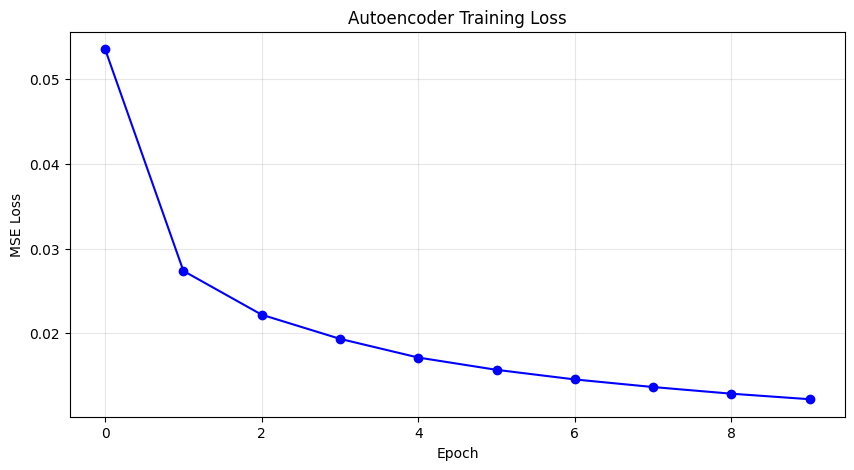

In [19]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, 'b-o')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Autoencoder Training Loss')
plt.grid(True, alpha=0.3)
plt.show()

# **Visualizing Reconstructions**

Let's see how well the autoencoder reconstructs the input images!

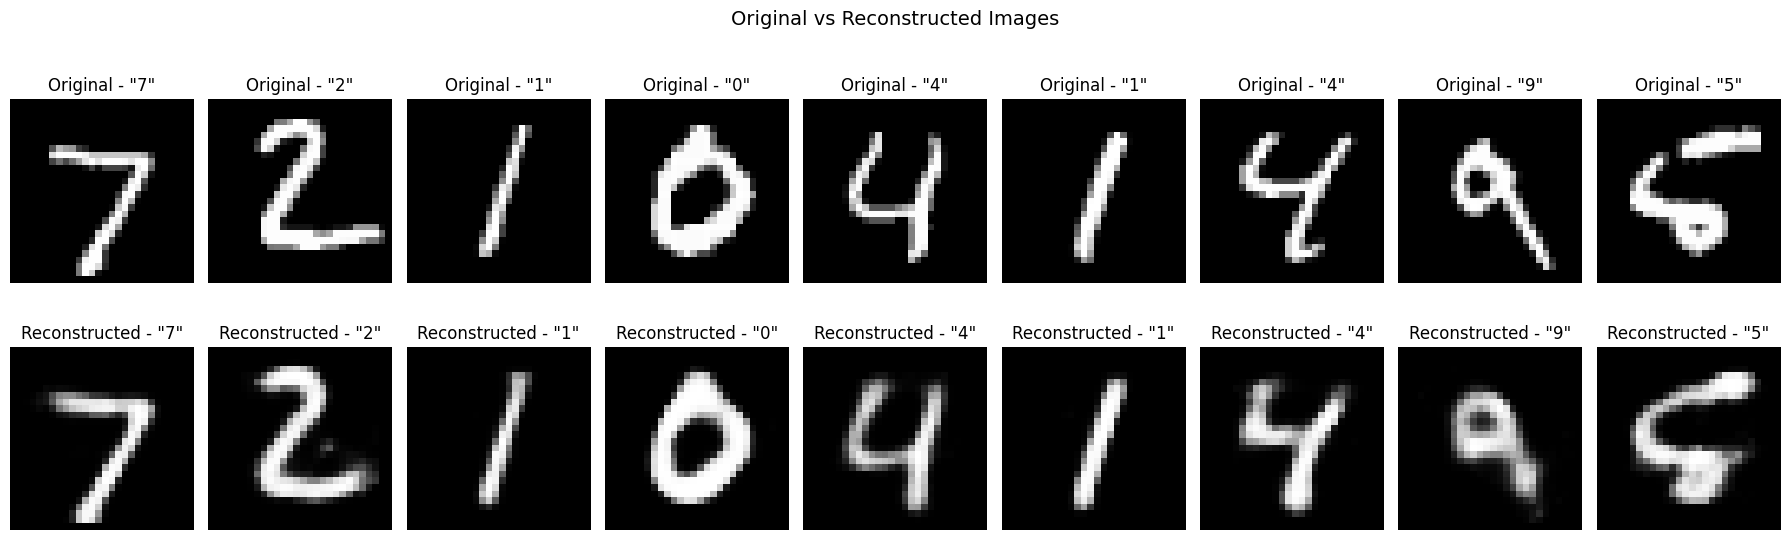

In [20]:
# Get some test images
model.eval()

test_images, test_labels = next(iter(test_loader))
test_images = test_images.to(device)

with torch.no_grad():
  reconstructed = model(test_images)

# Move to CPU for plotting
test_images = test_images.cpu()
reconstructed = reconstructed.cpu()

# Plot original vs reconstructed
n_images = 9
fig, axes = plt.subplots(2, n_images, figsize=(18, 6))

for i in range(n_images):
  # Original
  axes[0, i].imshow(test_images[i].squeeze(), cmap='gray')
  axes[0, i].axis('off')
  axes[0, i].set_title(f'Original - "{test_labels[i]}"', fontsize=12)

  # Reconstructed
  axes[1, i].imshow(reconstructed[i].squeeze(), cmap='gray')
  axes[1, i].axis('off')
  axes[1, i].set_title(f'Reconstructed - "{test_labels[i]}"', fontsize=12)

plt.suptitle('Original vs Reconstructed Images', fontsize=14)
plt.tight_layout()
plt.show()

# **Generating New Images** 🙂‍↕️

One cool use case of autoencoders: we can **generate new images** by:
1. Sampling random z vectors in the latent space
2. Passing them through the decoder

> **Note:** Simple autoencoders don't structure the latent space well, so generated images may look noisy.

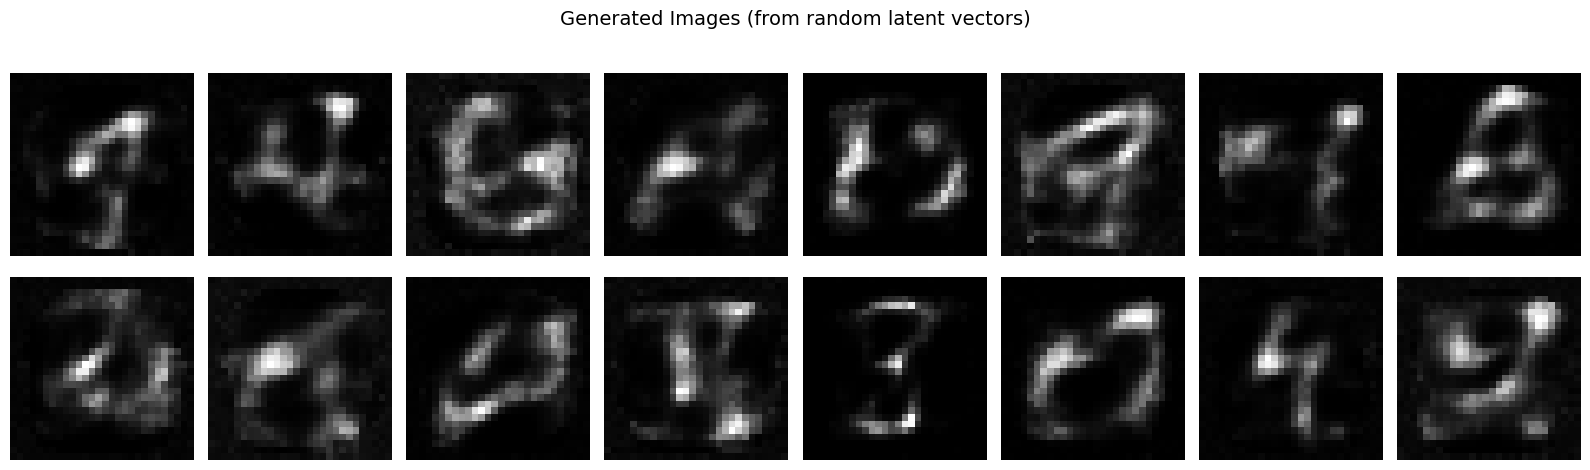

In [21]:
# Generate new images by sampling from latent space
model.eval()

# Sample random vectors from the latent space
# We'll sample from a normal distribution with similar statistics to encoded data
n_samples = 16
z_random = torch.randn(n_samples, LATENT_DIM) * 2
z_random = z_random.to(device)

with torch.no_grad():
  generated = model.decode(z_random)

generated = generated.cpu()

# Plot generated images
fig, axes = plt.subplots(2, 8, figsize=(16, 5))

for i, ax in enumerate(axes.flat):
  ax.imshow(generated[i].squeeze(), cmap='gray')
  ax.axis('off')

plt.suptitle('Generated Images (from random latent vectors)', fontsize=14)
plt.tight_layout()
plt.show()

> **Observation:** The generated images may look like "digit-like" patterns but aren't perfect. This is because:
> 1. Simple autoencoders don't regularize the latent space
> 2. Random samples may fall outside the learned distribution



---

### **Contributed by: Sattam Altwaim :)**



![image.jpeg](https://i.imgur.com/8NyQ1AH.jpeg)